<a href="https://colab.research.google.com/github/hansuho113/SwUniv_CancerAnalysis/blob/main/Colab_Notebook/Suho/ternary_TCGA_durg_res%2C_gene_exp_SUHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [250]:
from google.colab import drive  
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as dp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# drug-response data set

In [252]:
drug_res = pd.read_table("/content/drive/MyDrive/SW21Project/TCGA_Drug_Response_07272017.txt")
drug_res

,Cancer Type,bcr_patient_barcode,drug_name,measure_of_response,regimen_indication,days_to_drug_therapy_start,days_to_drug_therapy_end,therapy_types
0,ACC,TCGA-PK-A5HB,Sorafenib,Clinical Progressive Disease,NaN,968.0,1029.0,Targeted Molecular therapy
1,ACC,TCGA-OR-A5K2,Adriamycin,NaN,NaN,118.0,298.0,Chemotherapy
2,ACC,TCGA-OR-A5K2,Cisplatin,NaN,NaN,118.0,298.0,Chemotherapy
3,ACC,TCGA-OR-A5K2,carboplatin,NaN,NaN,118.0,299.0,Chemotherapy
4,ACC,TCGA-OR-A5K2,etoposide,NaN,NaN,118.0,298.0,Chemotherapy
...,...,...,...,...,...,...,...,...
12566,UCS,TCGA-N5-A4RU,Cisplatin,Complete Response,NaN,48.0,113.0,Chemotherapy
12567,UVM,TCGA-V4-A9F3,fotemustine,NaN,NaN,27.0,175.0,Chemotherapy
12568,UVM,TCGA-V4-A9F1,fotemustine,NaN,NaN,22.0,147.0,Chemotherapy
12569,UVM,TCGA-V4-A9ET,fotemustine,NaN,NaN,21.0,174.0,Chemotherapy


In [253]:
len(list(drug_res.bcr_patient_barcode.unique()))

4328

In [254]:
drug_res['Cancer Type'].value_counts()


# TCGA cancer codes
# (https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)

# COAD(: colon adenocarcinoma)
# 모든 상피 세포에서 기원한 악성 종양은 암종(carcinoma)이라고 부름.
# 암종도 더욱 세분되는데,
# 현미경적으로 선상피(glandular epithelium)의 모양을 가지면 선암종(adenocarcinoma)이라 함.

OV      2516
BRCA    2406
GBM     1505
LGG      695
COAD     593
UCEC     479
STAD     463
LUAD     461
LUSC     357
HNSC     353
BLCA     303
SKCM     265
PAAD     254
READ     231
DLBC     225
SARC     208
CESC     199
TGCT     171
KIRC     168
MESO     159
PRAD     130
UCS       95
ESCA      82
LIHC      66
THCA      56
KIRP      47
KICH      21
ACC       18
THYM      16
CHOL      14
PCPG      11
UVM        4
Name: Cancer Type, dtype: int64

In [255]:
cancer_type = list(drug_res['Cancer Type'].value_counts().index)
cancer_type_sum = drug_res['Cancer Type'].value_counts().tolist()
type_len = len(cancer_type)
x = np.arange(type_len)

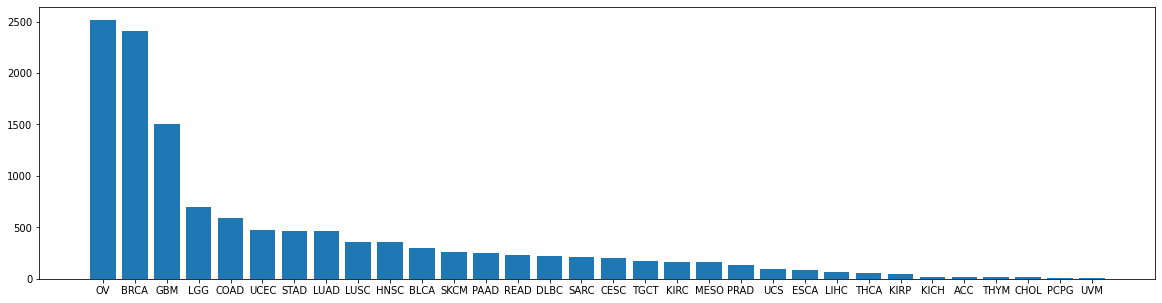

In [256]:
plt.figure(figsize=(20,5))
plt.bar(x, cancer_type_sum)
plt.xticks(x, cancer_type)
plt.show()

# COAD drug_res data set

In [257]:
drug_res_c = drug_res[drug_res['Cancer Type'] == "COAD"]

# index 재설정
drug_res_c.reset_index(drop=True, inplace=True)

In [258]:
len(drug_res_c.bcr_patient_barcode.unique().tolist())

154

## drug name

In [259]:
drug_list = drug_res['drug_name'].unique().tolist()
drug_for_COAD = drug_res_c['drug_name'].unique().tolist()

print(f"drug-response 데이터셋의 전체 약물 {len(drug_list)} 개 중 COAD에 사용된 약물은 {len(drug_for_COAD)} 개")

drug-response 데이터셋의 전체 약물 1065 개 중 COAD에 사용된 약물은 66 개


### drug name preprocessing

In [260]:
drug_res_c.drug_name.unique()

# 적용 약물명 replace로 통일해야 함
# 5-FU, 5 FU 이런 것들
# 5-에프유주 - 플루오로우라실(Fluorouracil), 5-Fluorouracil, 5-에프유, 5-FU, FU
# http://cancer.snuh.org/info/medi/view.do?seq_no=51 (5 FU 약물 설명 / 서울대학교 암병원)


array(['5-FU', 'Oxaliplatin', 'Cetuximab Study drug', 'Leucovorin',
       '5 FU', 'Folinic acid', '5-Fluorouracil', nan, 'XELODA', '5FU',
       'Fluorouracil', 'oxaliplatin', 'Folinic Acid', 'Cetuximab',
       'Bevacizumab', 'Irinotecan', 'Avastin', 'Xeloda', 'Folfox',
       'Capecitabine', 'capecitabine', 'Floxuridine', 'Dexamethasone',
       'Irinotecan HCl', 'Pegfilgrastim', 'Leucovorin Calcium',
       'IRINOtecan HCl', 'Mitomycin', 'Camptosar',
       'Calcium Foliatum, fluorouracilum, oxaliplatinum, dexamethassone',
       'oxaliplatinum+5 fluorouracilum', '5- FU', 'Raltitrexed',
       'leucovorin', 'fluorouracil', 'Erbitux', 'avastin', 'irinotecan',
       'leucovorin calcium', 'bevacizumab', 'regorafenib',
       'Pegfilgrastim (Peg G-CSF)', 'Filgrastim (G-CSF)',
       'Irinotecan HCL', 'C1 FOLFIRI/Zaltrap', 'Irinotecan + Cetuximab',
       'FOLFIRI/Avastin', 'FOLFOX', '5-Fluorouracil + leucovorin',
       'FolFox', 'Oxaliplatin, Folinic acid, Fluorouracil', 'Panitumumab

In [261]:
fluorouracil_list = ["5-FU", "5 FU", "5-Fluorouracil", "5FU", "Fluorouracil","5- FU", "fluorouracil",
                     "FLUOROURACIL", "5-Fluoruoracil"]   # 9
oxaliplatin_list = ["Oxaliplatin", "oxaliplatin", "OXALIPLATIN"]    # 3
cetuximab_list = ["Cetuximab Study drug", "Cetuximab", "CETUXimab",
                  "Erbitux"]     # 4
# 얼비툭스, Erbitux - 세툭시맙(Cetuximab) / 서울대학교 암병원

folinic_list = ["Leucovorin", "Leucovorin Calcium", "leucovorin", "leucovorin calcium", "Levcovorin",
                "Folinic acid", "Folinic Acid", ]     # 7
# Folinic acid, also known as leucovorin,
# is a medication used to decrease the toxic effects of methotrexate and pyrimethamine.

regorafenib_list = ["regorafenib"]  # 1
raltitrexed_list = ["Raltitrexed"]  # 1
motomycin_list = ['Mitomycin', "Mitomycin C"]   # 2
pegfilgrastim_list = ['Pegfilgrastim', "Pegfilgrastim (Peg G-CSF)"] # 2
filgrastim_list = ["Filgrastim (G-CSF)"]    # 1
dexamethasone_list = ["Dexamethasone"]  # 1
floxuridine_list = ["Floxuridine"]  # 1

capecitabine_list = ["XELODA", "Xeloda", "Capecitabine", "capecitabine"]    # 4
# Xeloda라는 브랜드로 판매되는 Capecitabine은 유방암, 위암 및 대장 암을 치료하는 데 사용되는 화학 요법 약물입니다.

bevacizumab_list = ["Bevacizumab", "bevacizumab", "BEVACIZUMAB", "BEVACIZumab", "Avastin", "avastin"]  # 6
# 베바시주맙(bevacizumab, 상표명: Avastin)

panitumumab_list = ['Panitumumab']    # 1

irinotecan_list = ["Irinotecan", "Irinotecan HCl", "IRINOtecan HCl", "irinotecan", "Irinotecan HCL", "CPT-11",
                   "Camptosar", ]   #7
# CPT-11(irinotecan) is a promising new agent for the treatment of colorectal cancer with a unique mechanism of action
# 특히 Camptosar라는 브랜드 이름으로 판매되는 Irinotecan은 결장암 및 소세포 폐암 치료에 사용되는 약물입니다.
irinotecan_cetuximab = ["Irinotecan + Cetuximab"]   # 1

folfiri_list = ["FOLFIRI", "Folfiri"]   # 2
folfiri_zal_list = ["C1 FOLFIRI/Zaltrap"]   # 1
folfiri_ava_list = ["FOLFIRI/Avastin"]  # 1

# Folinic acid, fluorouracil and irinotecan (FOLFIRI)
# FOLFIRI is the name of a chemotherapy combination that includes:
# - folinic acid (also called leucovorin, calcium folinate or FA)
# - fluorouracil (also called 5FU)
# - irinotecan
# https://www.cancerresearchuk.org/about-cancer/cancer-in-general/treatment/cancer-drugs/drugs/folfiri

folfox_list = ["Folfox", "FOLFOX", "FolFox", "Oxaliplatin, Folinic acid, Fluorouracil"] # 4
# FOLFOX: made up of the drugs Folinic acid (leucovorin) "FOL", Fluorouracil (5-FU) "F", and Oxaliplatin (Eloxatin) "OX"

folfox_dex_list = ["Calcium Foliatum, fluorouracilum, oxaliplatinum, dexamethassone"]   # 1
fox_list = ["oxaliplatinum+5 fluorouracilum", "oxaliplatinum+ 5-FU"]    # 2
folf_list = ["5-Fluorouracil + leucovorin", 'Mayo 425-20']  # 2
# Standard Dose (Mayo Regimen) 5-Fluorouracil and Low Dose Folinic Acid
# https://www.researchgate.net/publication/232159892_Standard_Dose_Mayo_Regimen_5-Fluorouracil_and_Low_Dose_Folinic_Acid_Prohibitive_Toxicity

conatumumab_list = ['Study drug AMG 655']   # 1
# Conatumumab (originally AMG-655) is a monoclonal antibody developed for the treatment of cancer.

nan_list = ['nan']  # 1

In [262]:
# 나중에 각 list 별 in 연산자를 통해서 drug_name 통일할 예정

In [263]:
len(drug_res_c.drug_name.unique().tolist())
# drug_res_c.drug_name.unique()의 길이와 동일 -> 누락된 값 없이 잘 매칭됨

66

In [264]:
drug_dict = {"fluorouracil" : fluorouracil_list,
"oxaliplatin":oxaliplatin_list,
"cetuximab":cetuximab_list,
"folinic":folinic_list,
"regorafenib":regorafenib_list,
"raltitrexed":raltitrexed_list,
"motomycin":motomycin_list,
"pegfilgrastim":pegfilgrastim_list,
"filgrastim":filgrastim_list,
"dexamethasone":dexamethasone_list,
"floxuridine":floxuridine_list,
"capecitabine":capecitabine_list,
"bevacizumab":bevacizumab_list,
"panitumumab":panitumumab_list,
"irinotecan":irinotecan_list,
"irino_cetux":irinotecan_cetuximab,
"folfiri":folfiri_list,
"folfiri_zal":folfiri_zal_list,
"folfiri_ava":folfiri_ava_list,
"folfox":folfox_list,
"folfox_dex":folfox_dex_list,
"fox":fox_list,
"folf":folf_list,
"conatumumab":conatumumab_list,
"nan":nan_list}

In [265]:
drug_res_c['integrated_name'] = np.nan
# 약물명 통일을 위해 nan을 default로 하는 "integated_name"이라는 새로운 컬럼 생성

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [266]:
for r, each_row in enumerate(range(len(drug_res_c))):
    name = drug_res_c.iloc[r,2]     # drug_res_c 데이터프레임의 각 row별 drug_name 값
    drug_list = list(drug_dict.keys())     # drug_dict의 key값 리스트

    for i, each_dict in enumerate(drug_dict.values()):
        if name in each_dict:    # drug_dict value에 들어있는 drug_name_list 각각에 속해있는지 확인
            drug_res_c.iloc[r,8] = drug_list[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## drug_response 3 class로 분류

In [267]:
response_list = ["Complete Response", "Partial Response"]
no_response_list = ["Clinical Progressive Disease", "Stable Disease"]

In [268]:
drug_res_c

,Cancer Type,bcr_patient_barcode,drug_name,measure_of_response,regimen_indication,days_to_drug_therapy_start,days_to_drug_therapy_end,therapy_types,integrated_name
0,COAD,TCGA-D5-5539,5-FU,NaN,ADJUVANT,38.0,195.0,Chemotherapy,fluorouracil
1,COAD,TCGA-A6-6648,Oxaliplatin,NaN,"OTHER, SPECIFY IN NOTES",63.0,91.0,NaN,oxaliplatin
2,COAD,TCGA-A6-6648,Cetuximab Study drug,NaN,"OTHER, SPECIFY IN NOTES",63.0,77.0,NaN,cetuximab
3,COAD,TCGA-A6-6648,Leucovorin,NaN,"OTHER, SPECIFY IN NOTES",63.0,91.0,NaN,folinic
4,COAD,TCGA-A6-6648,5 FU,NaN,"OTHER, SPECIFY IN NOTES",63.0,93.0,NaN,fluorouracil
...,...,...,...,...,...,...,...,...,...
588,COAD,TCGA-A6-2674,Leucovorin,NaN,RECURRENCE,761.0,944.0,"Other, specify in notesancillary",folinic
589,COAD,TCGA-A6-2674,Bevacizumab,NaN,RECURRENCE,761.0,944.0,Targeted Molecular therapy,bevacizumab
590,COAD,TCGA-A6-2674,Oxaliplatin,NaN,RECURRENCE,761.0,944.0,Chemotherapy,oxaliplatin
591,COAD,TCGA-A6-2674,Fluorouracil,NaN,RECURRENCE,761.0,946.0,Chemotherapy,fluorouracil


In [269]:
drug_res_c.measure_of_response.value_counts()

Complete Response               126
Clinical Progressive Disease     80
Partial Response                 33
Stable Disease                   15
Name: measure_of_response, dtype: int64

In [270]:
drug_res_c.measure_of_response.unique()

array([nan, 'Complete Response', 'Clinical Progressive Disease',
       'Partial Response', 'Stable Disease'], dtype=object)

In [271]:
drug_res_c.integrated_name.value_counts()

fluorouracil     180
folinic          127
oxaliplatin      115
bevacizumab       48
irinotecan        39
capecitabine      33
cetuximab         15
folfox             6
floxuridine        5
pegfilgrastim      4
motomycin          3
fox                2
folfiri            2
folfox_dex         2
folf               2
folfiri_ava        1
raltitrexed        1
regorafenib        1
panitumumab        1
irino_cetux        1
filgrastim         1
conatumumab        1
dexamethasone      1
folfiri_zal        1
Name: integrated_name, dtype: int64

In [272]:
drug_type = list(drug_res_c['integrated_name'].value_counts().index)
drug_type_sum = drug_res_c['integrated_name'].value_counts().tolist()
type_len = len(drug_type)
x = np.arange(type_len)

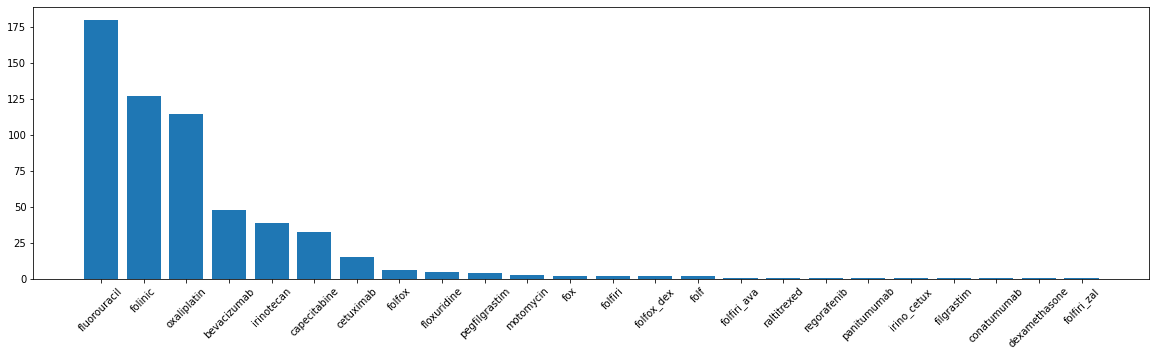

In [273]:
plt.figure(figsize=(20,5))
plt.bar(x, drug_type_sum)
plt.xticks(x, drug_type, rotation=45)
plt.show()

## measure of response

In [274]:
drug_res_c.measure_of_response.unique()

array([nan, 'Complete Response', 'Clinical Progressive Disease',
       'Partial Response', 'Stable Disease'], dtype=object)

### 암의 경우 진행성 질환은 치료 초기부터 종양 크기나 종양의 확산이 최소 20% 이상 증가하는 것으로 정의된다. 즉, 스캔에서 종양의 크기가 20% 더 크면 진행성 질병이라고 불립니다.
https://www.verywellhealth.com/definition-of-progressive-disease-2249171

### 고형암 반응 평가 기준(RECIST)

#### 완전관해(반응) CR: complete response
    - 관찰되었던 모든 종양이 완전 소실되고 적어도 4주 간격, 2번 관찰을 통해서 새로운 종양이 관찰되지 않은 경우

#### 부분관해(반응) PR: partial response
    - 적어도 4주 간경, 2번 관찰을 통하여 측정되어지는 모든 종양의 50% 감소를 보이는 경우

#### 안정성질환 SD: stable disease
    - CR / PR 또는 PD에 해당되지 않는 경우, 즉 그대로인 상태

#### 진행성질환 PD: progressive disease
    - 하나 또는 그 이상의 종양 크기가 25% 이상 증가한 경우, 또는 새로운 종양이 관찰되는 경우


- 그러나 WHO 정의 를 사용하면서 몇 가지 문제점이 제기되었는데, 즉, 연구자간에 종양 크기 변화, 특히 종양의 단경과 숫자 변 화를 측정하는 방법에 차이가 있었으며, 진행(PD)의 정의에 한 개의 종양 크기 변화로 정의하는 연구자가 있 는 반면 모든 종양 크기 변화의 합계로 정의하는 연구자도 있어 통일되지 못한 결과가 나타났다. 또한 최근 CT, MRI 등의 발전으로 가능해진 3차원적인 영상에 의한 종양 크기 변화를 적절하게 반영하지 못하는 단점도 있었다
.

이를 극복하기 위해 2000년 Response evaluation criteria in solid tumors (RECIST) 정의와 2009년 RECIST v. 1.1이 발표되어 표적 및 비표적 병변들 모두에서 치료 반응을 평가한 뒤 이를 바탕으로 전체적인 치료 반응 평가 (overall response)를 권고하고 있다.

먼저 표적 병변들에 대한 치료 반응 평가로, 완전 관해 (CR): 관찰되었던 모든 표적 병변의 소실 및 병리학적 림프절이 10 mm미만으로 감소; 부분 관해(PR): 모든 표적 병변의 장경 합이 30% 이상 감소; 불변(SD): 완전 관해(CR)/부분 관해(PR) 또는 진행(PD)에 해당되지 않는 경우; 진행(PD): 모든 표적 병변의 장경 합이 20%이상 증가하고, 그 절대값의 합이 최소 5 mm 이상 증 가하거나 또는 새로운 종양이 관찰되는 경우로 정의하였다. 비표적 병변의 치료 반응 평가는, 완전 관해(CR): 모든 비표적 병변의 소실 및 종양표지자 수치의 정상화 그리고 모든 림프절 크기가 10 mm 이하; 비관해/비 진행(Non-CR/Non-PD): 한 개 이상의 비표적 병변이 계속 존재하거나/존재하며 상승된 종양표지자 수치가 계 속 유지되는 경우; 진행(PD): 기존의 비표적 병변이 명료하게 진행하거나 또는 새로운 병변이 생기는 경우로 정의하였다. 


## therapy types

In [275]:
drug_res_c.therapy_types.unique()

array(['Chemotherapy', nan, 'Other, specify in notesAncillary agent',
       'Ancillary', 'Targeted Molecular therapy',
       'Other, specify in notesAncillary', 'Immunotherapy',
       'Other, specify in notesLeucovorin', 'Other, specify in notes',
       'Other, specify in notesPhase III Clinical Trial',
       'Other, specify in notesAncillary Agent',
       'Other, specify in notesProtocol AMG 20060464',
       'Other, specify in notesancillary'], dtype=object)

## regimen indication

In [276]:
drug_res_c.regimen_indication.unique()

array(['ADJUVANT', 'OTHER, SPECIFY IN NOTES', nan, 'PROGRESSION',
       'RECURRENCE', 'PALLIATIVE'], dtype=object)

- regimen: 요법
- adjuvant: 보조제, 보강제
    - adjuvant chemotherapy: 보조항암화학요법
- progression: 진행
- recurrence: 재발
- palliative: 완화, 경감



# gene_expression DataSet

In [277]:
gene_exp = pd.read_csv("/content/drive/MyDrive/SW21Project/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep='\t')
gene_exp

,gene_id,TCGA-OR-A5J1-01A-11R-A29S-07,TCGA-OR-A5J2-01A-11R-A29S-07,TCGA-OR-A5J3-01A-11R-A29S-07,TCGA-OR-A5J5-01A-11R-A29S-07,TCGA-OR-A5J6-01A-31R-A29S-07,TCGA-OR-A5J7-01A-11R-A29S-07,TCGA-OR-A5J8-01A-11R-A29S-07,TCGA-OR-A5J9-01A-11R-A29S-07,TCGA-OR-A5JA-01A-11R-A29S-07,TCGA-OR-A5JB-01A-11R-A29S-07,TCGA-OR-A5JC-01A-11R-A29S-07,TCGA-OR-A5JD-01A-11R-A29S-07,TCGA-OR-A5JE-01A-11R-A29S-07,TCGA-OR-A5JF-01A-11R-A29S-07,TCGA-OR-A5JG-01A-11R-A29S-07,TCGA-OR-A5JI-01A-11R-A29S-07,TCGA-OR-A5JJ-01A-11R-A29S-07,TCGA-OR-A5JK-01A-11R-A29S-07,TCGA-OR-A5JL-01A-11R-A29S-07,TCGA-OR-A5JM-01A-11R-A29S-07,TCGA-OR-A5JO-01A-11R-A29S-07,TCGA-OR-A5JP-01A-11R-A29S-07,TCGA-OR-A5JQ-01A-11R-A29S-07,TCGA-OR-A5JR-01A-11R-A29S-07,TCGA-OR-A5JS-01A-11R-A29S-07,TCGA-OR-A5JT-01A-11R-A29S-07,TCGA-OR-A5JV-01A-11R-A29S-07,TCGA-OR-A5JW-01A-11R-A29S-07,TCGA-OR-A5JX-01A-11R-A29S-07,TCGA-OR-A5JY-01A-31R-A29S-07,TCGA-OR-A5JZ-01A-11R-A29S-07,TCGA-OR-A5K0-01A-11R-A29S-07,TCGA-OR-A5K1-01A-11R-A29S-07,TCGA-OR-A5K2-01A-11R-A29S-07,TCGA-OR-A5K3-01A-11R-A29S-07,TCGA-OR-A5K4-01A-11R-A29S-07,TCGA-OR-A5K5-01A-11R-A29S-07,TCGA-OR-A5K6-01A-11R-A29S-07,TCGA-OR-A5K8-01A-11R-A29S-07,...,TCGA-AB-3011-03A-01T-0736-13,TCGA-AB-3012-03A-01T-0736-13,TCGA-BR-4191-01A-02R-1131-13,TCGA-BR-4201-01A-01R-1131-13,TCGA-BR-4253-01A-01R-1131-13,TCGA-BR-4255-01A-01R-1131-13,TCGA-BR-4256-01A-01R-1131-13,TCGA-BR-4267-01A-01R-1131-13,TCGA-BR-4279-01A-01R-1131-13,TCGA-BR-4294-01A-01R-1131-13,TCGA-BR-4357-01A-01R-1157-13,TCGA-BR-4361-01A-01R-1157-13,TCGA-BR-4362-01A-01R-1157-13,TCGA-BR-4363-01A-01R-1157-13,TCGA-BR-4366-01A-01R-1157-13,TCGA-BR-4367-01A-01R-1157-13,TCGA-BR-4368-01A-01R-1157-13,TCGA-BR-4369-01A-01R-1157-13,TCGA-BR-4370-01A-01R-1157-13,TCGA-BR-4371-01A-01R-1157-13,TCGA-CG-4301-01A-01R-1157-13,TCGA-CG-4304-01A-01R-1157-13,TCGA-CG-4305-01A-01R-1157-13,TCGA-CG-4306-01A-01R-1157-13,TCGA-CG-4436-01A-01R-1157-13,TCGA-CG-4438-01A-01R-1157-13,TCGA-CG-4440-01A-01R-1157-13,TCGA-CG-4442-01A-01R-1157-13,TCGA-CG-4443-01A-01R-1157-13,TCGA-CG-4444-01A-01R-1157-13,TCGA-CG-4449-01A-01R-1157-13,TCGA-CG-4462-01A-01R-1157-13,TCGA-CG-4465-01A-01R-1157-13,TCGA-CG-4466-01A-01R-1157-13,TCGA-CG-4469-01A-01R-1157-13,TCGA-CG-4472-01A-01R-1157-13,TCGA-CG-4474-01A-02R-1157-13,TCGA-CG-4475-01A-01R-1157-13,TCGA-CG-4476-01A-01R-1157-13,TCGA-CG-4477-01A-01R-1157-13
0,?|100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3861,0.0000,0.0000,0.0000,1.5256,0.0000,0.0000,0.0000,0.4392,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8637,1.2937,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,?|100133144,3.2661,2.6815,1.7301,0.0000,0.0000,1.1673,1.4422,0.0000,4.4556,7.1293,2.6463,4.3811,0.0000,2.7763,0.0000,1.4709,1.1914,7.8032,7.7097,2.5862,3.5634,0.0000,0.7485,3.1549,1.3873,7.7887,3.6241,4.3835,4.9359,0.0000,4.8564,1.8235,0.8281,1.2870,4.3467,3.8827,13.0179,0.0000,0.0000,...,17.716369,13.389132,14.071057,11.329452,3.723643,0.152714,0.766700,7.700615,0.572036,29.644535,9.686832,31.496379,18.108204,15.339604,7.821240,4.951610,26.780123,23.150730,14.112944,23.614495,16.465764,4.507328,24.503813,12.814032,6.796057,17.552167,8.944041,13.948436,10.855999,8.078055,4.358154,5.676995,5.219350,14.846708,20.115492,6.997533,18.311906,12.057112,18.628740,17.874417
2,?|100134869,3.9385,8.9948,6.5650,1.5492,4.4709,6.0529,2.2876,1.3599,5.0581,0.0000,6.2595,4.1141,2.8281,4.5603,5.9116,5.0046,3.7171,1.3501,4.0357,0.0000,1.8357,9.2227,1.2422,1.5399,6.0118,9.2668,2.0872,8.3414,11.2794,2.6870,5.2191,2.9334,0.8281,3.0317,9.8836,4.5214,7.6527,7.0671,7.2569,...,8.711105,6.345575,10.396725,4.624286,5.023468,3.777147,4.109257,8.784211,0.216067,5.791117,7.940472,4.980171,6.212606,7.841276,5.536552,6.141207,4.013048,10.749562,10.540668,11.177682,4.501637,2.945732,5.272467,3.459179,0.556227,6.962577,1.460478,8.518132,4.211036,1.903348,2.6

## Merge the two DataSet (drug_res, gene_exp)
- bcr_patient_barcode in drug_res
- gene_exp의 각 column의 앞 10자리 index
    - 데이터가 커서 전치 불가

In [278]:
patients_drug_res = list(drug_res_c.bcr_patient_barcode.unique())    # drug_res_c 데이터의 환자 유일값
len(patients_drug_res)
# 중복 제거 전 -> 593

154

In [279]:
patients_gene = list(gene_exp.columns[1:])
print(f"patients_gene 길이 : {len(patients_gene)} ('gene_id' 제외)")
print()
print(f"gene_exp 데이터의 컬럼명 형식: {patients_gene[0]}")

patients_gene 길이 : 11069 ('gene_id' 제외)

gene_exp 데이터의 컬럼명 형식: TCGA-OR-A5J1-01A-11R-A29S-07


In [280]:
# dataframe 전치는 데이터가 너무 커서 메모리 부족
# 컬럼명을 리스트로 만들어서 인덱스로 접근해서 따로 뽑을 예정

# bcr_patients_barcode와 맞추기 위해 문자열 앞 12개만 추출
patients_gene_c = list(map(lambda x: x[:12], patients_gene))
patients_gene_c[0]

'TCGA-OR-A5J1'

In [281]:
# # < list index example >
# a = ['a','b','c']
# b = 'b'

# a.index(b)
# >>> 1

patients_gene_c_idx = []    # gene_exp 데이터에서 drug_res_c의 유일한 환자와 일치하는 컬럼 인덱스 값 리스트
for patient in patients_drug_res:
    try:
        patients_gene_c_idx.append(patients_gene_c.index(patient))
    except:
        continue

In [282]:
len(patients_gene_c_idx)

150

In [283]:
patients_gene_c_idx[:10]

[3602, 3436, 9393, 3715, 3523, 3514, 3694, 3547, 3677, 3503]

In [284]:
gene_id = list(gene_exp.gene_id)

gene_exp_c = gene_exp.iloc[:,patients_gene_c_idx].T    # gene_exp 데이터 중 drug_res의 bcr_patient_barcode와 일치하는 컬럼만 추출
gene_exp_c.columns = gene_id

gene_exp_c.reset_index(drop=False, inplace=True)

In [285]:
gene_exp_patients_full = list(gene_exp_c['index'])    # gene_exp_c 데이터에서 index값으로 들어간 환자 바코드 전체
gene_exp_patients_part = list(map(lambda x: x[:12], gene_exp_patients_full))     # drug_res 데이터와 merge 하기 위해 환자 바코드 일부만 추출
gene_exp_patients_part = pd.DataFrame(gene_exp_patients_part, columns=['bcr_patient_barcode'])


## 보기 쉽게 환자 바코드 10자리를 앞으로 가져오기 위해 컬럼 추가 대신 concat으로 붙여줌
gene_exp_c = pd.concat([gene_exp_patients_part, gene_exp_c], axis=1)

In [286]:
print(len(gene_exp_c))
gene_exp_c.fillna(0, inplace=True)
dp(gene_exp_c.tail(2))

150


,bcr_patient_barcode,index,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG|1,A1CF|29974,A2BP1|54715,A2LD1|87769,A2M|2,A2ML1|144568,A4GALT|53947,A4GNT|51146,AAA1|404744,...,ZPBP2|124626,ZPLD1|131368,ZRANB1|54764,ZRANB2|9406,ZRANB3|84083,ZRSR2|8233,ZSCAN10|84891,ZSCAN1|284312,ZSCAN12|9753,ZSCAN12P1|221584,ZSCAN16|80345,ZSCAN18|65982,ZSCAN20|7579,ZSCAN21|7589,ZSCAN22|342945,ZSCAN23|222696,ZSCAN2|54993,ZSCAN29|146050,ZSCAN4|201516,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
148,TCGA-AA-A00R,TCGA-AA-A00R-01A-01R-A002-07,0.0,6.728379,15.490982,611.415564,1328.533089,0.0,133.036973,0.0,0.0,0.0,0.0,0.818211,2.281055,0.0,0.0,0.0,0.0,0.0,0.0,758.020424,10.321519,0.0,99.502786,0.0,0.0,0.0,-0.263372,940.524144,0.452986,48.29776,5.841883,-0.330564,124.716321,3930.168920,-0.321153,294.14556,0.0,0.0,...,0.0,0.0,659.545293,1306.776961,34.772191,251.34597,0.225811,0.025724,35.604177,94.637383,96.556642,73.248099,46.837355,119.601586,105.542429,-0.297134,95.183629,413.893957,0.0,112.557224,2.905679,207.708060,0.0,64.227368,229.896917,511.779354,196.227860,118.452298,247.616249,527.989857,784.706259,1993.840906,30.370242,253.258446,845.065579,1.494204,599.374709,4893.579712,1436.854661,605.743185
149,TCGA-A6-2672,TCGA-A6-2672-01A-01R-0826-07,0.0,11.827684,11.496231,586.589191,950.933702,0.0,357.177909,0.0,0.0,0.0,0.0,0.329156,10.355338,0.0,0.0,0.0,0.0,0.0,0.0,1312.746963,9.406661,0.0,182.326315,0.0,0.0,0.0,-0.263372,786.427536,0.561088,53.39939,15.782182,-0.330564,292.828204,4505.206924,-0.321153,147.70400,0.0,0.0,...,0.0,0.0,534.537236,1965.253438,75.466808,181.38050,0.313280,0.100900,103.989207,56.268288,113.223994,97.306700,55.683127,143.117088,86.619994,1.535168,91.093998,396.094596,0.0,100.126977,5.181362,270.086779,0.0,43.801173,247.813854,82.217304,355.979398,124.504213,219.441362,469.931665,723.221353,1000.177429,21.441247,297.670423,733.994308,-0.402069,722.605149,6035.961594,1744.735947,488.184971


## merge 문제
- gene_exp 데이터 컬럼과 drug_res_c 데이터의 환자 bcr_patient_barcode 컬럼을 이용해서 일치하는 gene_expression만 추출
- 컬럼 환자 bcr_patient_barcode는 154개 였는데 일치하는 건 150개로 나옴..

## 상위 약물 6개에 대한 drug_res 환자만 추출하고 이에 맞는 gene_exp 데이터 merge

In [287]:
drug_top6 = list(drug_res_c.integrated_name.value_counts().keys()[:6])    # 사용량 상위 6개 약물
drug_top6

['fluorouracil',
 'folinic',
 'oxaliplatin',
 'bevacizumab',
 'irinotecan',
 'capecitabine']

In [288]:
index_for_drop = []
for i in range(len(drug_res_c)):
    if drug_res_c.iloc[i, -1] not in drug_top6:
        index_for_drop.append(i)    # 나중에 한꺼번에 drop하기 위해 index_for_drop list에 담아둠

In [289]:
print(f"사용량 상위 6개 약물의 합: {drug_res_c.integrated_name.value_counts()[:6].sum()}")
print(f"drug_res_c 전체 약물 수 : {len(drug_res_c)}")
print()
print(f"위 두 숫자의 차이 = (len(index_for_drop)): {len(index_for_drop)}")
print("즉, 상위 6개 약물이 542번 사용되었고 그 외 약물이 51번 사용됨")

사용량 상위 6개 약물의 합: 542
drug_res_c 전체 약물 수 : 593

위 두 숫자의 차이 = (len(index_for_drop)): 51
즉, 상위 6개 약물이 542번 사용되었고 그 외 약물이 51번 사용됨


In [290]:

drug6_res_c = drug_res_c.drop(index_for_drop)

# 약물 반응성 척도
response_list = ["Complete Response", "Partial Response"]
no_response_list = ["Clinical Progressive Disease", "Stable Disease"]
res_dict = {"response" : response_list, "no response" : no_response_list}

drug6_res_c['therapy_response'] = np.nan

for r, each_row in enumerate(range(len(drug6_res_c))):
  name = drug6_res_c.iloc[r,3]
  res_list = list(res_dict.keys())

  for i, each_dict in enumerate(res_dict.values()):
    if name in each_dict:
      drug6_res_c.iloc[r,9] = res_list[i]

drug6_res_c.fillna("unknown", inplace=True)
drug6_res_c

# ## theraphy_periods 컬럼 추가
# drug6_res_c["therapy_period"] = drug6_res_c.days_to_drug_therapy_end - drug6_res_c.days_to_drug_therapy_start
# drug6_res_c

# https://www.biostars.org/p/126631/
# days_to_drug_theraphy columns 설명

,Cancer Type,bcr_patient_barcode,drug_name,measure_of_response,regimen_indication,days_to_drug_therapy_start,days_to_drug_therapy_end,therapy_types,integrated_name,therapy_response
0,COAD,TCGA-D5-5539,5-FU,unknown,ADJUVANT,38,195,Chemotherapy,fluorouracil,unknown
1,COAD,TCGA-A6-6648,Oxaliplatin,unknown,"OTHER, SPECIFY IN NOTES",63,91,unknown,oxaliplatin,unknown
3,COAD,TCGA-A6-6648,Leucovorin,unknown,"OTHER, SPECIFY IN NOTES",63,91,unknown,folinic,unknown
4,COAD,TCGA-A6-6648,5 FU,unknown,"OTHER, SPECIFY IN NOTES",63,93,unknown,fluorouracil,unknown
5,COAD,TCGA-AA-3560,Folinic acid,Complete Response,unknown,31,212,Chemotherapy,folinic,response
...,...,...,...,...,...,...,...,...,...,...
588,COAD,TCGA-A6-2674,Leucovorin,unknown,RECURRENCE,761,944,"Other, specify in notesancillary",folinic,unknown
589,COAD,TCGA-A6-2674,Bevacizumab,unknown,RECURRENCE,761,944,Targeted Molecular therapy,bevacizumab,unknown
590,COAD,TCGA-A6-2674,Oxaliplatin,unknown,RECURRENCE,761,944,Chemotherapy,oxaliplatin,unknown
591,COAD,TCGA-A6-2674,Fluorouracil,unknown,RECURRENCE,761,946,Chemotherapy,fluorouracil,unknown


In [291]:
# patients_drug6_res = list(set(drug6_res_c.bcr_patient_barcode))
# patients_gene_exp = list(gene_exp_c.bcr_patient_barcode)

# not_match_patients = []    # 불일치 환자 명단
# match_patients = []

# for patient in patients_gene_exp:

#     # gene_exp_c의 환자 바코드와 drug6_res_c 환자 바코드 비교
#     # gene_exp_c의 개별 환자바코드를 하나씩 순회하면서 drug6_res_c의 환자 바코드 리스트에 있는지 파악
#     # 일치하는 게 있어야만 merge 가능한 것임

#     if patient not in patients_drug6_res:
#         not_match_patients.append(patient)
#     else:
#         match_patients.append(patient)

In [292]:

# print(f"drug6_res_c 데이터의 총 Row 길이는 {len(drug6_res_c)} 이고, 이 중 중복되지 않는 환자는 {len(patients_drug6_res)}명임")
# print(".    상위 약물 6개로 추리기 전에는 154명")
# print(f"gene_exp_c 데이터의 총 Row 길이는 {len(gene_exp_c)} 이고, 독립적이라 row개수와 환자 수 동일")
# print()
# print(f"위 코드에서 gene_exp_c와 drug6_res_c의 환자 바코드가 일치하는 경우는 {len(match_patients)} 이고, 불일치하는 경우는 {len(not_match_patients)} 임")
# print()
# print(f"""
# durg_res 전체 데이터의 unique한 환자 수는 {len(list(drug_res.bcr_patient_barcode.unique()))} 명 이고,
# gene_exp 전체 데이터의 unique한 환자 수는 {len(list(gene_exp.columns))} 명임
# """)

## merge 문제
- drug6_res_c의 환자 바코드와 gene_exp_c의 환자 바코드가 94개 불일치
    - 약물 반응을 기록한 환자들 중 94명은 gene-expression 데이터가 없다는 것..?

In [293]:
drug_gene_c = pd.merge(drug6_res_c, gene_exp_c, how='left', on='bcr_patient_barcode')
drug_gene_c.dropna(subset=['index'], inplace=True)    # index column에 NaN이 있으면 삭제
drug_gene_c.reset_index(drop=True, inplace=True)

# drug_gene_c.to_csv("drug_gene_c.csv")

In [294]:
drug_gene_c.head(2)

,Cancer Type,bcr_patient_barcode,drug_name,measure_of_response,regimen_indication,days_to_drug_therapy_start,days_to_drug_therapy_end,therapy_types,integrated_name,therapy_response,index,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,...,ZPBP2|124626,ZPLD1|131368,ZRANB1|54764,ZRANB2|9406,ZRANB3|84083,ZRSR2|8233,ZSCAN10|84891,ZSCAN1|284312,ZSCAN12|9753,ZSCAN12P1|221584,ZSCAN16|80345,ZSCAN18|65982,ZSCAN20|7579,ZSCAN21|7589,ZSCAN22|342945,ZSCAN23|222696,ZSCAN2|54993,ZSCAN29|146050,ZSCAN4|201516,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,COAD,TCGA-A6-6648,Oxaliplatin,unknown,"OTHER, SPECIFY IN NOTES",63,91,unknown,oxaliplatin,unknown,TCGA-A6-6648-01A-11R-1774-07,0.0,14.1703,12.2592,324.308,713.85,0.0,152.732,0.5083,0.0,0.0,0.0,3.0496,2.033,0.0,0.0,0.0,0.0,0.0,0.0,732.147,12.4524,0.0,31.5121,0.0,0.0,2.033,0.5083,506.48,0.5083,...,0.0,0.2541,737.992,1298.83,116.9,160.864,0.0,0.2541,224.905,33.5451,178.145,461.245,85.6417,142.473,158.831,4.3202,134.943,722.745,0.0,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59
1,COAD,TCGA-A6-6648,Leucovorin,unknown,"OTHER, SPECIFY IN NOTES",63,91,unknown,folinic,unknown,TCGA-A6-6648-01A-11R-1774-07,0.0,14.1703,12.2592,324.308,713.85,0.0,152.732,0.5083,0.0,0.0,0.0,3.0496,2.033,0.0,0.0,0.0,0.0,0.0,0.0,732.147,12.4524,0.0,31.5121,0.0,0.0,2.033,0.5083,506.48,0.5083,...,0.0,0.2541,737.992,1298.83,116.9,160.864,0.0,0.2541,224.905,33.5451,178.145,461.245,85.6417,142.473,158.831,4.3202,134.943,722.745,0.0,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59


In [295]:
drug_gene_c2 = drug_gene_c.drop(['Cancer Type','drug_name', 'days_to_drug_therapy_start', 'days_to_drug_therapy_end'], axis=1)

# 환자 바코드 전체를 index로 했다가 다시 reset_index -> 맨 앞 컬럼으로 이동할 수 있음
drug_gene_c2.set_index("index", inplace=True)
drug_gene_c2.reset_index(inplace=True)

In [296]:
drug_gene_c2.head(2)

,index,bcr_patient_barcode,measure_of_response,regimen_indication,therapy_types,integrated_name,therapy_response,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG|1,A1CF|29974,A2BP1|54715,A2LD1|87769,...,ZPBP2|124626,ZPLD1|131368,ZRANB1|54764,ZRANB2|9406,ZRANB3|84083,ZRSR2|8233,ZSCAN10|84891,ZSCAN1|284312,ZSCAN12|9753,ZSCAN12P1|221584,ZSCAN16|80345,ZSCAN18|65982,ZSCAN20|7579,ZSCAN21|7589,ZSCAN22|342945,ZSCAN23|222696,ZSCAN2|54993,ZSCAN29|146050,ZSCAN4|201516,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,unknown,"OTHER, SPECIFY IN NOTES",unknown,oxaliplatin,unknown,0.0,14.1703,12.2592,324.308,713.85,0.0,152.732,0.5083,0.0,0.0,0.0,3.0496,2.033,0.0,0.0,0.0,0.0,0.0,0.0,732.147,12.4524,0.0,31.5121,0.0,0.0,2.033,0.5083,506.48,0.5083,6.7929,191.614,6.8615,101.741,...,0.0,0.2541,737.992,1298.83,116.9,160.864,0.0,0.2541,224.905,33.5451,178.145,461.245,85.6417,142.473,158.831,4.3202,134.943,722.745,0.0,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59
1,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,unknown,"OTHER, SPECIFY IN NOTES",unknown,folinic,unknown,0.0,14.1703,12.2592,324.308,713.85,0.0,152.732,0.5083,0.0,0.0,0.0,3.0496,2.033,0.0,0.0,0.0,0.0,0.0,0.0,732.147,12.4524,0.0,31.5121,0.0,0.0,2.033,0.5083,506.48,0.5083,6.7929,191.614,6.8615,101.741,...,0.0,0.2541,737.992,1298.83,116.9,160.864,0.0,0.2541,224.905,33.5451,178.145,461.245,85.6417,142.473,158.831,4.3202,134.943,722.745,0.0,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59


In [297]:
print(drug_gene_c2.measure_of_response.unique())
print(drug_gene_c2.regimen_indication.unique())
print(drug_gene_c2.therapy_types.unique())
# print(drug_gene_c2.therapy_period.unique())

['unknown' 'Complete Response' 'Partial Response'
 'Clinical Progressive Disease' 'Stable Disease']
['OTHER, SPECIFY IN NOTES' 'ADJUVANT' 'RECURRENCE' 'PROGRESSION' 'unknown']
['unknown' 'Chemotherapy' 'Other, specify in notesAncillary'
 'Targeted Molecular therapy' 'Ancillary' 'Immunotherapy'
 'Other, specify in notesAncillary Agent'
 'Other, specify in notesancillary']


In [298]:
drug_gene_c2

,index,bcr_patient_barcode,measure_of_response,regimen_indication,therapy_types,integrated_name,therapy_response,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG|1,A1CF|29974,A2BP1|54715,A2LD1|87769,...,ZPBP2|124626,ZPLD1|131368,ZRANB1|54764,ZRANB2|9406,ZRANB3|84083,ZRSR2|8233,ZSCAN10|84891,ZSCAN1|284312,ZSCAN12|9753,ZSCAN12P1|221584,ZSCAN16|80345,ZSCAN18|65982,ZSCAN20|7579,ZSCAN21|7589,ZSCAN22|342945,ZSCAN23|222696,ZSCAN2|54993,ZSCAN29|146050,ZSCAN4|201516,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,unknown,"OTHER, SPECIFY IN NOTES",unknown,oxaliplatin,unknown,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
1,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,unknown,"OTHER, SPECIFY IN NOTES",unknown,folinic,unknown,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
2,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,unknown,"OTHER, SPECIFY IN NOTES",unknown,fluorouracil,unknown,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
3,TCGA-AZ-4615-01A-01R-1410-07,TCGA-AZ-4615,unknown,ADJUVANT,Chemotherapy,capecitabine,unknown,0.0,25.104200,23.888800,258.457000,1157.460000,0.0,59.828100,0.4711,0.0,0.0,0.0,0.000000,8.950700,0.0,0.0,0.0,0.0,0.0,0.0,975.150000,1.884300,0.0000,324.579000,0.0,0.0,0.4711,0.000000,801.319000,0.471100,24.162100,11.306100,0.000000,165.036000,...,0.4711,0.0000,518.196000,836.085000,30.620700,104.110000,0.000000,0.000000,60.299100,63.530800,97.043900,98.457200,45.695400,122.030000,84.795700,1.41330,141.326000,452.715000,3.7687,82.440200,1.88430,206.336000,0.0,71.605200,203.981000,190.790000,268.048000,114.66300,199.741000,762.690000,602.88300,1385.000000,57.001500,377.812000,835.237000,0.471100,598.280000,5186.670000,1034.510000,522.4360
4,TCGA-G4-6297-01A-11R-1723-07,T

In [299]:
# drug_gene_c2_na_check = drug_gene_c2[drug_gene_c2.columns.difference(['index','bcr_patient_barcode','measure_of_response',
#                                                                       'regimen_indication', 'therapy_types', 'integrated_name',
#                                                                       'therapy_period'])]
# drug_gene_c2_na_check
                                                                      

In [300]:
drug_gene_c2_le = drug_gene_c2.copy()

## Label Encoding

In [301]:
# Label Encoding

encoder = LabelEncoder()
encoder.fit(drug_gene_c2.measure_of_response)

labels = encoder.transform(drug_gene_c2.measure_of_response)
labels, encoder.classes_

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        1, 1, 1, 1, 1, 1, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4,
        4, 4, 4, 1, 1, 1, 1, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4,
        4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 4,
        4, 4, 0, 0, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 2, 2, 2, 4, 4, 1, 1, 1,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4]), array(['Clinical Progressive Disease', 'Complete Response',
        'Partial Response', 'Stable Disease', 'unknown'], dtype=object))

In [302]:
def label_encoding(column):
    encoder = LabelEncoder()
    encoder.fit(column)
    labels = encoder.transform(column)
    return labels, encoder.classes_

In [303]:
columns_for_label_encod = ["measure_of_response", "regimen_indication", "therapy_types", 'integrated_name', 'therapy_response']
classes_list = []

for each_column in columns_for_label_encod:
    column = drug_gene_c2_le[each_column]
    labels, classes = label_encoding(column)
    classes_list.append(classes)    # label encoding class 저장
    drug_gene_c2_le[each_column] = list(labels)    # label encoding된 컬럼으로 기존 데이터프레임 컬럼 대체

In [304]:
drug_gene_c2_le

,index,bcr_patient_barcode,measure_of_response,regimen_indication,therapy_types,integrated_name,therapy_response,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,?|340602,?|388795,?|390284,?|391343,?|391714,?|404770,?|441362,?|442388,?|553137,?|57714,?|645851,?|652919,?|653553,?|728045,?|728603,?|728788,?|729884,?|8225,?|90288,A1BG|1,A1CF|29974,A2BP1|54715,A2LD1|87769,...,ZPBP2|124626,ZPLD1|131368,ZRANB1|54764,ZRANB2|9406,ZRANB3|84083,ZRSR2|8233,ZSCAN10|84891,ZSCAN1|284312,ZSCAN12|9753,ZSCAN12P1|221584,ZSCAN16|80345,ZSCAN18|65982,ZSCAN20|7579,ZSCAN21|7589,ZSCAN22|342945,ZSCAN23|222696,ZSCAN2|54993,ZSCAN29|146050,ZSCAN4|201516,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,4,1,7,5,2,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
1,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,4,1,7,3,2,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
2,TCGA-A6-6648-01A-11R-1774-07,TCGA-A6-6648,4,1,7,2,2,0.0,14.170300,12.259200,324.308000,713.850000,0.0,152.732000,0.5083,0.0,0.0,0.0,3.049600,2.033000,0.0,0.0,0.0,0.0,0.0,0.0,732.147000,12.452400,0.0000,31.512100,0.0,0.0,2.0330,0.508300,506.480000,0.508300,6.792900,191.614000,6.861500,101.741000,...,0.0000,0.2541,737.992000,1298.830000,116.900000,160.864000,0.000000,0.254100,224.905000,33.545100,178.145000,461.245000,85.641700,142.473000,158.831000,4.32020,134.943000,722.745000,0.0000,134.435000,1.77890,518.678000,0.0,309.022000,240.661000,703.939000,488.437000,110.06600,233.799000,892.503000,940.45500,1146.630000,66.836100,558.577000,988.310000,1.016500,1029.220000,2791.870000,2283.100000,1205.5900
3,TCGA-AZ-4615-01A-01R-1410-07,TCGA-AZ-4615,4,0,1,1,2,0.0,25.104200,23.888800,258.457000,1157.460000,0.0,59.828100,0.4711,0.0,0.0,0.0,0.000000,8.950700,0.0,0.0,0.0,0.0,0.0,0.0,975.150000,1.884300,0.0000,324.579000,0.0,0.0,0.4711,0.000000,801.319000,0.471100,24.162100,11.306100,0.000000,165.036000,...,0.4711,0.0000,518.196000,836.085000,30.620700,104.110000,0.000000,0.000000,60.299100,63.530800,97.043900,98.457200,45.695400,122.030000,84.795700,1.41330,141.326000,452.715000,3.7687,82.440200,1.88430,206.336000,0.0,71.605200,203.981000,190.790000,268.048000,114.66300,199.741000,762.690000,602.88300,1385.000000,57.001500,377.812000,835.237000,0.471100,598.280000,5186.670000,1034.510000,522.4360
4,TCGA-G4-6297-01A-11R-1723-07,TCGA-G4-6297,4,0,1,5,2,0.0,11.797700,9.774700,415.609000,619.367000,0.0,228.188000,0.4794,0.0,0.0,0.0,0.958800,2.876300,0.0,0.0,0.0,0.0,0.0,0.0,1156.280000,8.149600,9.2905,132.311000,0.0,0.0,0.00

In [305]:
# "measure_of_response", "regimen_indication", "therapy_types", 'integrated_name'
classes_list

[array(['Clinical Progressive Disease', 'Complete Response',
        'Partial Response', 'Stable Disease', 'unknown'], dtype=object),
 array(['ADJUVANT', 'OTHER, SPECIFY IN NOTES', 'PROGRESSION', 'RECURRENCE',
        'unknown'], dtype=object),
 array(['Ancillary', 'Chemotherapy', 'Immunotherapy',
        'Other, specify in notesAncillary',
        'Other, specify in notesAncillary Agent',
        'Other, specify in notesancillary', 'Targeted Molecular therapy',
        'unknown'], dtype=object),
 array(['bevacizumab', 'capecitabine', 'fluorouracil', 'folinic',
        'irinotecan', 'oxaliplatin'], dtype=object),
 array(['no response', 'response', 'unknown'], dtype=object)]

## Split the data

In [306]:
data = np.array(drug_gene_c2_le[drug_gene_c2_le.columns.difference(["index", "bcr_patient_barcode", 'measure_of_response', 'therapy_response'])])
target = np.array(drug_gene_c2_le.therapy_response)

In [307]:
np.asarray(data).astype('float32')

# Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# one of the columns from my data had boolean values. Converting everything into np.float32 solved the issue!
# https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte

array([[ 0.      , 14.1703  , 12.2592  , ...,  1.      ,  0.      ,
         7.      ],
       [ 0.      , 14.1703  , 12.2592  , ...,  1.      ,  0.      ,
         7.      ],
       [ 0.      , 14.1703  , 12.2592  , ...,  1.      ,  0.      ,
         7.      ],
       ...,
       [ 0.      ,  7.809006,  5.477651, ...,  3.      ,  0.      ,
         1.      ],
       [ 0.      ,  7.809006,  5.477651, ...,  3.      ,  0.      ,
         1.      ],
       [ 0.      ,  7.809006,  5.477651, ...,  3.      ,  0.      ,
         1.      ]], dtype=float32)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [309]:
X_train.shape[1:]

(20534,)

In [310]:
inputs = keras.Input(shape=X_train.shape[1:])
dense = layers.Dense(300, activation='relu')

x = dense(inputs)
x = layers.Dense(200, activation='relu')(x)

x = layers.Dense(100, activation='relu')(x)

outputs = layers.Dense(3, activation='softmax')(x)

In [311]:
# 모델 생성
model = keras.Model(inputs=inputs, outputs=outputs, name='drug_res_prediction')
model.summary()

Model: "drug_res_prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 20534)]           0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               6160500   
_________________________________________________________________
dense_25 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 303       
Total params: 6,241,103
Trainable params: 6,241,103
Non-trainable params: 0
_________________________________________________________________


In [312]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [313]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2)

Epoch 1/50
5/5 [==============================] - 1s 88ms/step - loss: 16885.0519 - accuracy: 0.4571 - val_loss: 6026.7603 - val_accuracy: 0.4054
Epoch 2/50
5/5 [==============================] - 0s 44ms/step - loss: 5937.5184 - accuracy: 0.5973 - val_loss: 4603.4189 - val_accuracy: 0.6486
Epoch 3/50
5/5 [==============================] - 0s 45ms/step - loss: 2381.8703 - accuracy: 0.7169 - val_loss: 1295.6184 - val_accuracy: 0.6216
Epoch 4/50
5/5 [==============================] - 0s 48ms/step - loss: 1411.9820 - accuracy: 0.6893 - val_loss: 1012.6253 - val_accuracy: 0.5135
Epoch 5/50
5/5 [==============================] - 0s 42ms/step - loss: 1514.1116 - accuracy: 0.4527 - val_loss: 1094.8914 - val_accuracy: 0.7297
Epoch 6/50
5/5 [==============================] - 0s 48ms/step - loss: 1536.2265 - accuracy: 0.6175 - val_loss: 1696.1368 - val_accuracy: 0.7027
Epoch 7/50
5/5 [==============================] - 0s 44ms/step - loss: 1436.3930 - accuracy: 0.6783 - val_loss: 1492.2981 - val_a

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)    # 수직축 범위 [0-1] 사이로 설정
plt.show()

In [314]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 14ms/step - loss: 210.2214 - accuracy: 0.8710


[210.2213897705078, 0.8709677457809448]

In [315]:
# drug_gene_c2.dropna(subset=['measure_of_response'], axis=0, inplace=True)
# drug_gene_c2

# # measure of response NaN 값 drop하면 245 -> 87개..

In [316]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [317]:

predict_classes=np.argmax(y_proba,axis=1)
predict_classes

array([0, 2, 1])

In [318]:
# suplmt_df = pd.read_excel("/content/drive/MyDrive/SW21Project/TCGA-CDR-SupplementalTableS1.xlsx", index_col=0)
# suplmt_coad = suplmt_df[suplmt_df['type'] == 'COAD']
# suplmt_coad
# patient_list_suplmt = suplmt_coad.bcr_patient_barcode.unique().tolist()
# patient_list_drug = drug_res_c.bcr_patient_barcode.unique().tolist()

# len(patient_list_drug), len(patient_list_suplmt)
# # supplement table은 환자의 개인신상정보를 담고 있는 것 같은데 459명이고, 앞서 나온 drug-response의 환자는 총 154명으로 전체 환자의 약물반응성을 측정한 것은 아닌 것 같음



In [319]:
# suplmt_coad.treatment_outcome_first_course.value_counts()

In [320]:
# suplmt_coad.Redaction.value_counts()

In [321]:
# clinical_df = pd.read_excel("/content/drive/MyDrive/SW21Project/clinical_PANCAN_patient_with_followup.xlsx")
# clinical_coad = clinical_df[clinical_df['acronym'] == 'COAD']

In [322]:
# clinical_coad